In [95]:
'''
!pip install --pre pycaret
!pip install pycaret
from google.colab import drive
drive.mount('/content/drive')
'''

"\n!pip install --pre pycaret\n!pip install pycaret\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [96]:
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import files
import pandas as pd
import io
import numpy as np
import os

from datetime import datetime
#from download import download

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from google.colab import files
import time
import numpy as np
import pandas as pd
#import numpy as np
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
from statsmodels.tsa.stattools import kpss
mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['axes.grid']=False

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
#NECESSARY IMPORTS
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.api import VAR, adfuller, kpss
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
from keras.optimizers import RMSprop
from tensorflow.keras import Sequential, Model
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError , MeanAbsoluteError
from keras.layers import UpSampling1D,Input, Dense, SimpleRNN , Dropout,DepthwiseConv1D,Reshape, Attention, SpatialDropout1D,LSTM,LocallyConnected1D, GlobalMaxPooling1D,AveragePooling1D, Bidirectional, TimeDistributed, GRU, LayerNormalization, ConvLSTM1D
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.layers import Flatten, ConvLSTM2D
from keras.regularizers import l1, l2
from keras.layers import RepeatVector
import time
import random
#!pip install pandasql
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
random.seed(1337)
np.random.seed(1337)
tf.random.set_seed(1337)
#import pandasql as ps
import matplotlib as mpl
import matplotlib.pyplot as plt
#from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals()) 
from sklearn.metrics import mean_squared_error

In [99]:
import os
dir_path='/content/drive/MyDrive/AI LAB CoLab/TS_datasets_processed/'

Dataset_list=["PM2.5_p09_data.csv",
              "Myocardial_infarction_heart_data.csv",
              "Tetuan_City_Power_Consumption_Zone1_processed.csv",
              "Daily_Sunspot_data.csv",
              "Healthy_control_heart_data.csv",
              "POWER_Point_Daily_Presure_Data.csv",
              "POWER_Point_Daily_Temperature_Data.csv",
              "Metro_Interstate_Traffic_Volume_PD.csv"]

path = os.path.join(dir_path, Dataset_list[0])

df= pd.read_csv(path)
df.head()


,PM2.5_p09_data
0,12.3
1,8.5
2,7.1
3,10.3
4,9.8


In [100]:
path

'/content/drive/MyDrive/AI LAB CoLab/TS_datasets_processed/PM2.5_p09_data.csv'

In [101]:
##########################################################
################ Data Preprocessing ######################
##########################################################

# Below function deals with converting the data into time series data with specific number of lags/window/timesteps

def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()


# Below class deals with the Z-score Normalization / Splitting of the DataSet
# Here Ratio of Test , Train and Split is 81:9:10
# It can be reset using changing the split variable in __init__ function

class Standardize:
  def __init__(self, df, split=0.20):
    self.data=df
    self.split=split
  def split_data(self):
    n=int(len(self.data)*self.split)
    train, test=self.data.iloc[:-n], self.data.iloc[-n:]
    n=int(len(train)*self.split)
    train, val=train.iloc[:-n], train.iloc[-n:]
    assert len(test)+len(train)+len(val)==len(self.data)
    return train, test, val
    '''
  def split_data_view(self):
    n=int(len(self.data)*self.split)
    train, test=self.data.iloc[:-n], self.data.iloc[-n:]
    n=int(len(train)*self.split)
    train, val=train.iloc[:-n], train.iloc[-n:]
    assert len(test)+len(train)+len(val)==len(self.data)
    return train, val
    '''
  def transform(self, data):
    data_s=(data-self.mu)/self.sigma
    return data_s
  def fit_transform(self):
    train, test, val=self.split_data()
    self.mu, self.sigma= train.mean(),train.std()
    train_s=self.transform(train)
    test_s=self.transform(test)
    val_s=self.transform(val)
    return train_s, test_s, val_s
    '''
  def fit_transform_view(self):
    train, test, val=self.split_data_view()
    self.mu, self.sigma= train.mean(),train.std()
    train_s=self.transform(train)
    test_s=self.transform(test)
    val_s=self.transform(val)
    return train_s, test_s, val_s
    '''
  def inverse(self, data):
    return (data*self.sigma)+self.mu
  def inverse_y(self, data):
    return (data*self.sigma[-1])+self.mu[-1]


# This function deals with getting out the X and Y out of the dataset
# Column earlier named as 'y' will be taken out for processing, rest will be kept as x

def features_target_ts(*args):
        y=[col.pop('y').values.reshape(-1,1) for col in args]
        #yk=[col.pop('var5(t)').values.reshape(-1,1) for col in args]
        x=[col.values.reshape(*col.shape,1) for col in args]
        return *y, *x



#####################################################
################# Model Creation ####################
#####################################################
def create_model(train, units, dropout=0.2):
        # Variable-length int sequences.

        
        model_LSTM = Sequential()  
        model_LSTM.add(LSTM(256,activation='relu',input_shape=(train.shape[1], train.shape[2])))
        model_LSTM.add(Dense(1))
        model_LSTM._name='LSTM'
                  
        model_GRU = Sequential()  
        model_GRU.add(GRU(256,activation='relu',input_shape=(train.shape[1], train.shape[2])))
        model_GRU.add(Dense(1))
        model_GRU._name='GRU'
                      
        model_RNN = Sequential()  
        model_RNN.add(SimpleRNN(256,activation='relu',input_shape=(train.shape[1], train.shape[2])))
        model_RNN.add(Dense(1))
        model_RNN._name='RNN'
                      
        model_BiLSTM = Sequential()  
        #model_BiLSTM.add(Bidirectional(LSTM(256,activation='relu',input_shape=(train.shape[1], train.shape[2]))))
        model_BiLSTM.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(train.shape[1], train.shape[2])))
        #print(model_BiLSTM.output_shape)
        model_BiLSTM.add(Flatten())
        #print(model_BiLSTM.output_shape)
        model_BiLSTM.add(Dense(1))
        #print(model_BiLSTM.output_shape)
        model_BiLSTM._name='BiLSTM'
        #model_BiLSTM.add(Dense(1))
                  
        model_CNN = Sequential()  
        model_CNN.add(Conv1D(filters=256, kernel_size=1,input_shape=(train.shape[1], train.shape[2])))
        model_CNN.add(Flatten())
        model_CNN.add(Dense(1))
        model_CNN._name='CNN'
        return  model_LSTM, model_GRU, model_CNN, model_RNN, model_BiLSTM

# This function is responsible for model compilation and training 
def train_model_ts(model, x_train, y_train, x_val, y_val, epochs=250, patience =5, batch_size=66):
          model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
          es=keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=patience)
          history=model.fit(x_train, y_train, shuffle=False, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val),callbacks=[es],verbose=0)
          return history

# This function is responsible for Loss and Validation Loss Graph along with Test Prediction
def plot_forecast(model, x_test, y_test, index, history):
          #fig, ax=plt.subplots(2,1)
          #(pd.Series(history.history['loss']).plot(style='k', alpha=0.50, title='Loss By Epoch',ax=ax[0], label='loss'))
          #(pd.Series(history.history['val_loss']).plot(style='k', alpha=0.50, title='Loss By Epoch',ax=ax[0], label='val_loss'))
          #ax[0].legend()
          predicted=model.predict(x_test)
          #pd.Series(y_test.reshape(-1), index=index).plot(style='k--', alpha=0.5, ax=ax[1], title='Forecast Vs Actual', label='actual')
          #pd.Series(predicted.reshape(-1), index=index).plot(style='k', ax=ax[1],  label='Forecast')
          #fig.tight_layout()
          #ax[1].legend()
          #plt.show()
          return predicted

def Measures(y_true,y_pred):
  '''All input in this function must be 'list' data structure'''

  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_percentage_error
  from sklearn.metrics import mean_absolute_error
  import math

  a=np.array(y_true)
  b=np.array(y_pred)
  rmse=math.sqrt(sum(pow(a-b,2))/len(a))
  mape=sum(abs((a-b)/b))/len(a)*100

  #print('rmse:',rmse)
  #print('mape:',mape)
  return([rmse,mape])

def DataTrainTestVal(df_new):   
    en_df=one_step_forecast(df_new, 12)
    #en_df

    #Object of Standardize class has been created with dataset as the parameter
    scale_en=Standardize(en_df)
    train_en, test_en, val_en=scale_en.fit_transform()
    
    # Spliting into test, train and validation set
    y_train_en, y_val_en, y_test_in, x_train_en, x_val_en, x_test_en= features_target_ts(train_en, val_en, test_en)
    return (y_train_en, y_val_en, y_test_in, x_train_en, x_val_en, x_test_en, test_en, scale_en, en_df, val_en, train_en) 



In [102]:
def MVL_Data_Generator(data_array,seasonality_min, view_max):
    data_length=len(data_array)
    Train_Data_Len=data_length*0.8

    print("..........view number=",view_max,".................")
    Views=[]
    ViewsDataset=[]
    seasonal=[seasonality_min]

    multiply=round((Train_Data_Len/view_max)/seasonality_min)

    seasonal=[seasonality_min]
    for i in seasonal:
      #print("Provided the Multiplication Factor: "+str(multiply)+" possible number of views is :"+str(round((Train_Data_Len/multiply)/i))+" for seasonality: "+str(i))
      Views.append(round((Train_Data_Len/multiply)/i))

    # creating view of the dataset.......................
    for j in seasonal:
      #print(len(data_array[-(j*multiply):-1].tolist()))
      ViewsDataset.append(data_array[-(j*multiply):-1].tolist())
      for i in range(1,view_max):
        #print(len(data_array[-(j*multiply)*(i+1):-(j*multiply)*(i)].tolist()))
        ViewsDataset.append(data_array[-(j*multiply)*(i+1):-(j*multiply)*(i)].tolist())
      #k+=1
    return(ViewsDataset)

#Finding the Seasonal minimum values................

def Seasonality_min_val(df):
    fh = 50 # or alternately fh = np.arange(1,13)
    fold = 5

    fig_kwargs={'renderer': 'notebook'}
    eda = TSForecastingExperiment()

    dd=eda.setup(data=df, fh=fh, fig_kwargs=fig_kwargs)

    k=pd.DataFrame(dd.significant_sps)

    seasonality=k.to_numpy().flatten()
    seasonality_min=np.amin(seasonality)
    return(seasonality_min)




In [103]:
def Model_Execution(models,x_train_en, y_train_en, x_val_en, y_val_en, x_test_en, y_test_in, test_en, scale_en, en_df, val_en, train_en, batch_size=64):
  view_accuracy=[]
  Test_Predictions=pd.DataFrame()
  Train_Predictions=pd.DataFrame()
  for i in models:
              #i.summary()
              print(i._name)
              history_en_proposed=train_model_ts(i, x_train_en, y_train_en, x_val_en, y_val_en,  batch_size=64)
              Test_len=len(y_test_in)
              #print("training History=", history_en_proposed)


              #print("Model Trained !!! ")

              test_predicted=plot_forecast(i, x_test_en, y_test_in, test_en.index, history_en_proposed)

              scaled_test_y=scale_en.inverse_y(y_test_in)
              #print("Model Predicted For Test Data!!! ")
              #print('len(x_test_en)',len(scaled_test_y))
              #print('x_test_en values:\n',scaled_test_y)

              
              scaled_Pred=scale_en.inverse_y(test_predicted)
              Act_Pred=scaled_Pred
              scaled_Pred=pd.DataFrame(scaled_Pred)
              ll=en_df.iloc[-Test_len:,-1:]

              RMSE_New=(mean_squared_error(scaled_Pred, ll)**0.5)
              #print('Data views number ===>',serial,'<========','RMSE_New:',RMSE_New)
              view_accuracy.append(RMSE_New)
              
              scaled_Pred=scaled_Pred.rename(columns={0:'hb'})
              ll['pd']=scaled_Pred['hb'].values
              ll.plot()

              val_prediction=plot_forecast(i, x_val_en, y_val_en, val_en.index, history_en_proposed)
              #print("Validation Data Predicted !!! ")
              scaled_valid_Pred=scale_en.inverse_y(val_prediction)
              valid_performance=Measures(y_val_en,scaled_valid_Pred)
              #print("..................valid_performance...........===",valid_performance)

              Training_prediction=plot_forecast(i, x_train_en, y_train_en, train_en.index, history_en_proposed)
              #print("Training Data Predicted !!! ")

              Total_Train_Prediction=np.append(Training_prediction, val_prediction)
              scaled_Train_Pred=scale_en.inverse_y(Total_Train_Prediction)
              Act_Train_Pred=scaled_Train_Pred

              #print("Model To be Executed :")
              #print(i)
              if i._name=='Proposed':
                  Test_Predictions['Proposed']=pd.DataFrame(Act_Pred)
                  Train_Predictions['Proposed']=pd.DataFrame(Act_Train_Pred)
              if i._name=='LSTM':
                  Test_Predictions['LSTM']=pd.DataFrame(Act_Pred)
                  Train_Predictions['LSTM']=pd.DataFrame(Act_Train_Pred)  
              if i._name=='GRU':
                  Test_Predictions['GRU']=pd.DataFrame(Act_Pred)
                  Train_Predictions['GRU']=pd.DataFrame(Act_Train_Pred)
              if i._name=='CNN':
                  Test_Predictions['CNN']=pd.DataFrame(Act_Pred)
                  Train_Predictions['CNN']=pd.DataFrame(Act_Train_Pred)
              if i._name=='RNN':
                  Test_Predictions['RNN']=pd.DataFrame(Act_Pred)
                  Train_Predictions['RNN']=pd.DataFrame(Act_Train_Pred)
              if i._name=='BiLSTM':
                  Test_Predictions['BiLSTM']=pd.DataFrame(Act_Pred)
                  Train_Predictions['BiLSTM']=pd.DataFrame(Act_Train_Pred)
  return(view_accuracy,valid_performance,Test_Predictions.values.tolist(),scaled_test_y, Total_Train_Prediction)


#Ensembling the model for multi-view learning....................................................................

def MultiviewEnsemble(Traditional_model_pred,view_predictions, y_test_original,valid_performance_val, view_max):
    
 
    #traditional model prediction value adjustment
    model_pred=Traditional_model_pred[0][:][:]
    Trad_model_pred=[]
    for k in model_pred:
      Trad_model_pred.append(k[0])

    #Multi-view ensemble of the predictions value adjustment
    
    views_model_pred=[]
    for l in range(len(view_predictions)):
      views_pred=view_predictions[l][:][:]
      #print("views_pred====>",views_pred,"view(l)====>",l)
      views_model_pred_i=[]
      for k in views_pred:
        views_model_pred_i.append(k[0])
      views_model_pred.append(views_model_pred_i)
    
    p=np.transpose(np.array(views_model_pred))
    mean_val_MVL=np.mean(p, axis=1)
    MVL_pred=mean_val_MVL
    #------------------------------------
  
    #converting y_true original in the list formate
    y_true=[]
    for i in range(len(y_test_original)):
      y_true.append(y_test_original[i][0].tolist())

    #checking the performances
    #print("len(y_true)",len(y_true),"len(Trad_model_pred)",len(Trad_model_pred))

    performance_model_trad=Measures(y_true,Trad_model_pred)
    #performance_MVL=Measures(y_true,MVL_pred)

    print("Traditional model performance:",performance_model_trad)
    #print("performance_MVL_without weighting:",performance_MVL)

    print("Validation performaces of views:", valid_performance_val)

    ###---------------------------------validation weighted performance-------------
     
    from sklearn.preprocessing import MinMaxScaler

    weights=np.array(valid_performance_val[1:])
    validation_weighted_means=[]
    for array in p:
      #print('array===>',array)
      #print('weighted sum:',(array*(weights/weights.sum())).sum())
      validation_weighted_means.append((array*(weights/weights.sum())).sum())

    performance_MVL_valid_weighted=Measures(y_true,validation_weighted_means)
    #print("validation Weighted Performance:", performance_MVL_valid_weighted)
    
    #2^x weighting method...........................................

    wt=[]
    wt_sum=0
    new_p=p
    valid_performance_val_RMSE=valid_performance_val[1:]
    p_zero_mat = np.zeros((len(p), 1))

    for q in range(view_max):
      wt=np.power( 2.71828,q)
      #print('wt=',wt)
      wt_sum=wt_sum+wt
      max_value = max(valid_performance_val_RMSE)
      max_index = valid_performance_val_RMSE.index(max_value)
      #print('index',max_index)
      #print('before wt', new_p[:,max_index],'indexed_=',max_index)
      #print('after wt', new_p[:,max_index]*wt,'indexed_=',max_index)

      p_zero_mat= np.column_stack((p_zero_mat, new_p[:,max_index]*wt))
      #p_i_wt=new_p[:,max_index]*wt
      valid_performance_val_RMSE[max_index]=0
      #accessing the predicted values and get multiplied with their weighte and append in new new _p_wtd
    
       
    weighted_means=[]
    for array in p_zero_mat[:,1:]:
      weighted_means.append((array.sum()/wt_sum))

    performance_MVL_valid_weighted_expo_2power=Measures(y_true,weighted_means)
    print("performance_MVL_valid_weighted_expo_2power:", performance_MVL_valid_weighted_expo_2power)

    #view wise accuracies.....
    print("view_Performance=", view_accuracy)

    return([view_max, performance_model_trad, performance_MVL_valid_weighted_expo_2power])

#This function calculate the gradient biase of the predictions.....................................
def GradientBias(train, train_predict,y_predict):
  diff=[]
  grad=[]
  #print('train len=',len(train),'train_predict len=', len(train_predict))
  for i in range(len(train)-1):
    diff.append(train[i]-train_predict[i])
    #print('diff:',train[i],'-',train_predict[i],'=', train[i]-train_predict[i])
    grad.append(train_predict[i+1]-train_predict[i])
    #print('grad:',train_predict[i+1],'-',train_predict[i],'=', train_predict[i+1]-train_predict[i])

  test_grad=[]
  #print("y_predict in GAB Fucntion:", y_predict)
  #print("train_predict in GAB Fucntion:", train_predict)
  #print("train in GAB Fucntion:", train)

  for i in range(len(y_predict)-1):
    test_grad.append(y_predict[i+1]-y_predict[i])

  #regression for the prediction
  final_diff=RegFun(grad,diff,test_grad)
  final_pred=[]
  for i in range(len(final_diff)):
    final_pred.append(y_predict[i]+final_diff[i])
  return(final_pred)


def RegFun(X,y,test_grad):
  from sklearn.ensemble import AdaBoostRegressor
  regr = AdaBoostRegressor(random_state=0, n_estimators=100)
  y=np.array(y)
  X=np.array(X).reshape(len(X),1)
  test_x=np.array(test_grad).reshape(len(test_grad),1)
  regr.fit(X,y)
  final_diff=regr.predict(test_x)
  return(final_diff)

,Description,Value
0,session_id,8887
1,Target,PM2.5_p09_data
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(43057, 1)"
5,Transformed data shape,"(43057, 1)"
6,Transformed train set shape,"(43007, 1)"
7,Transformed test set shape,"(50, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


..........view number= 2 .................
BiLSTM
861/861 [==============================] - 3s 3ms/step
length of the views: 17225
Data views number ============> 0 / 2 <================
BiLSTM
1077/1077 [==============================] - 4s 3ms/step
length of the views: 17226
Data views number ============> 1 / 2 <================
BiLSTM
1077/1077 [==============================] - 3s 3ms/step
Traditional model performance: [5.6654235375739805, 16.69392175011469]
Validation performaces of views: [24.737639283823167, 29.57271272031694, 29.575566996982054]
performance_MVL_valid_weighted_expo_2power: [5.531248546881528, 14.709681088647725]
view_Performance= [5.6654235375739805, [5.531822698561647], [5.532626706134259]]
Traditional model performance: [5.6654235375739805, 16.69392175011469]
Validation performaces of views: [24.737639283823167, 29.57271272031694, 29.575566996982054]
performance_MVL_valid_weighted_expo_2power: [4.498260859125567, 8.928550244533422]
view_Performance= [5.6654

KeyboardInterrupt: ignored

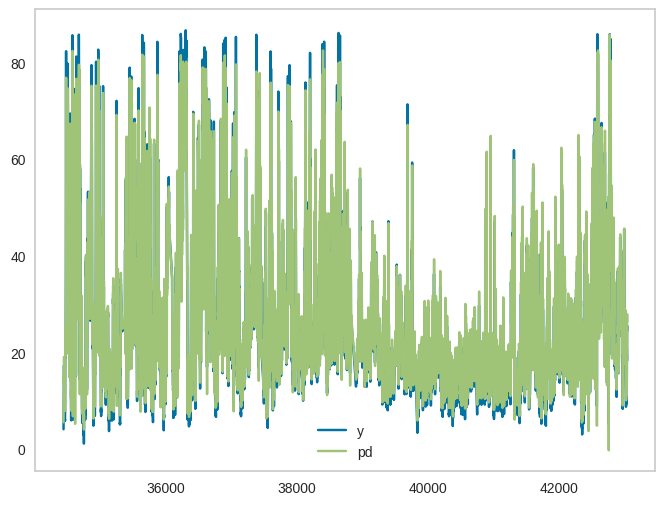

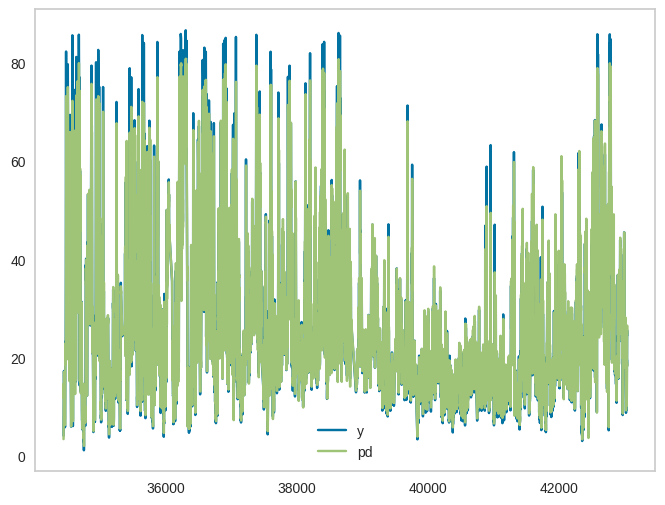

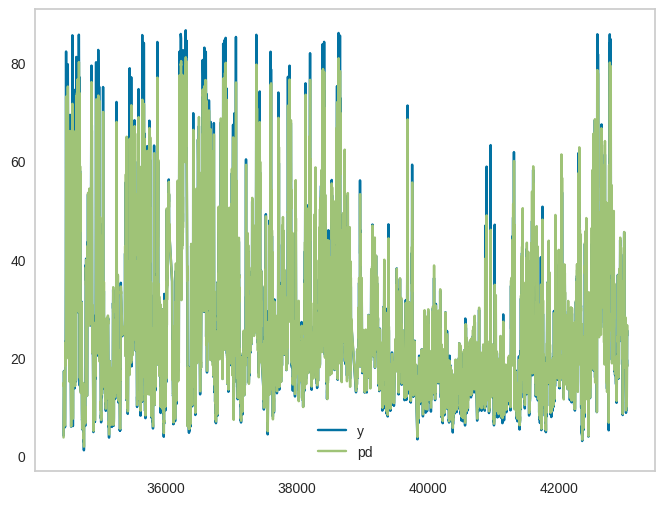

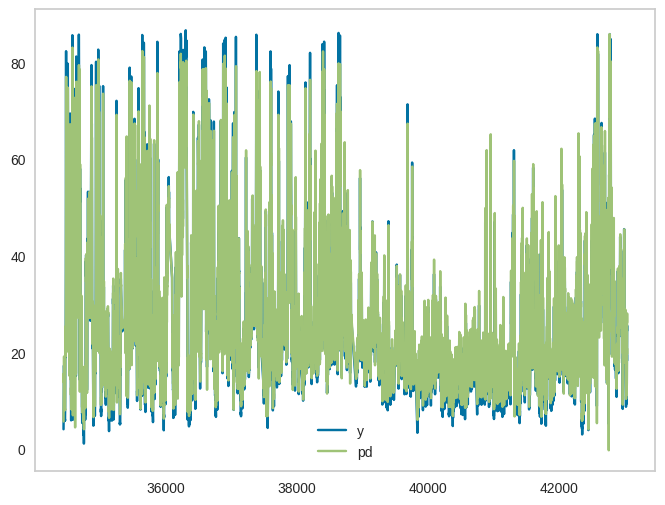

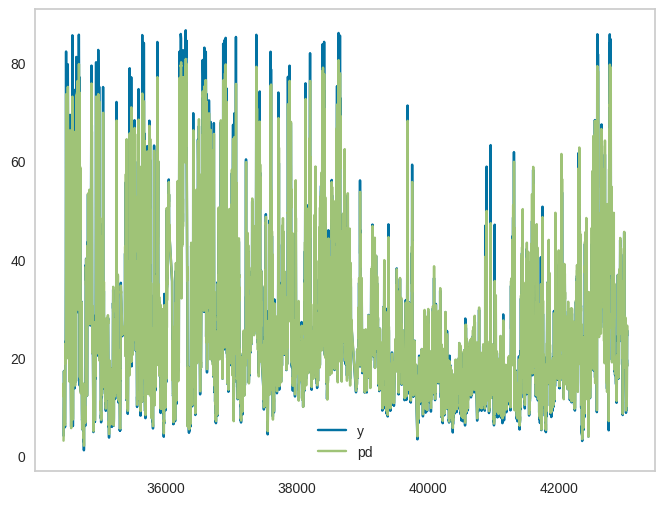

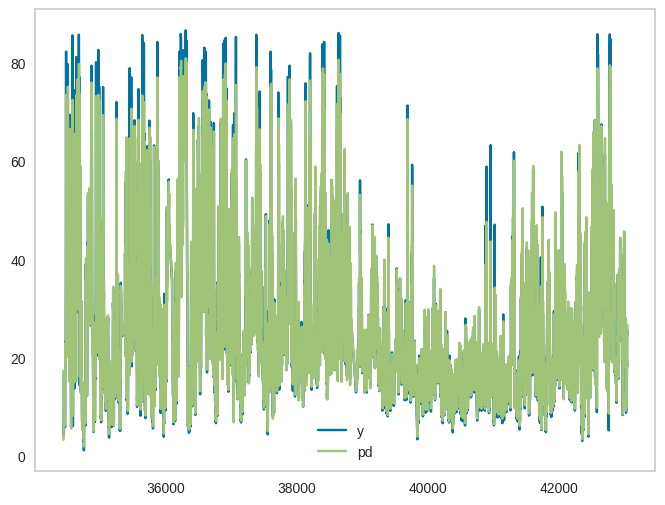

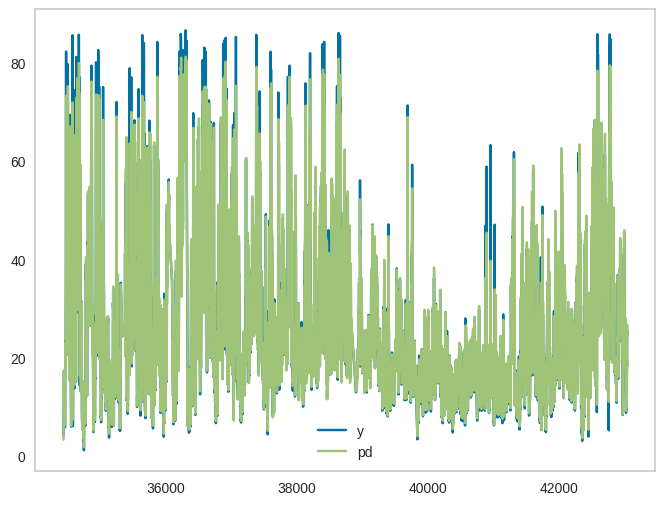

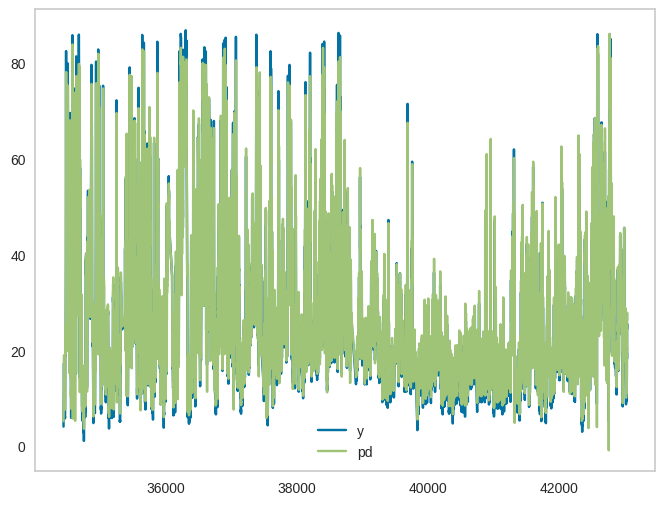

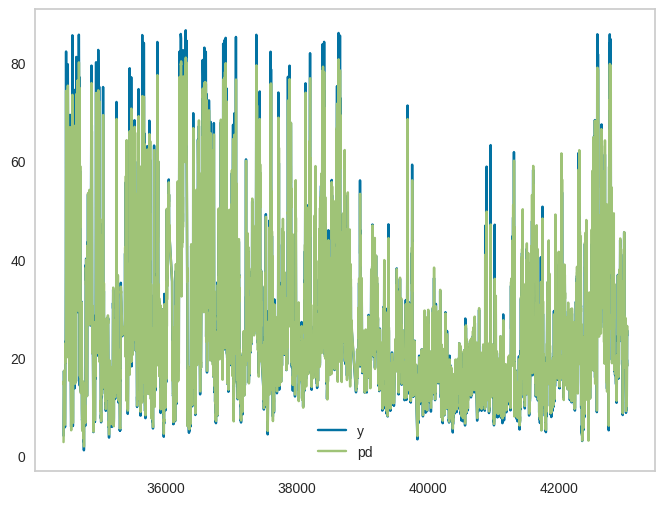

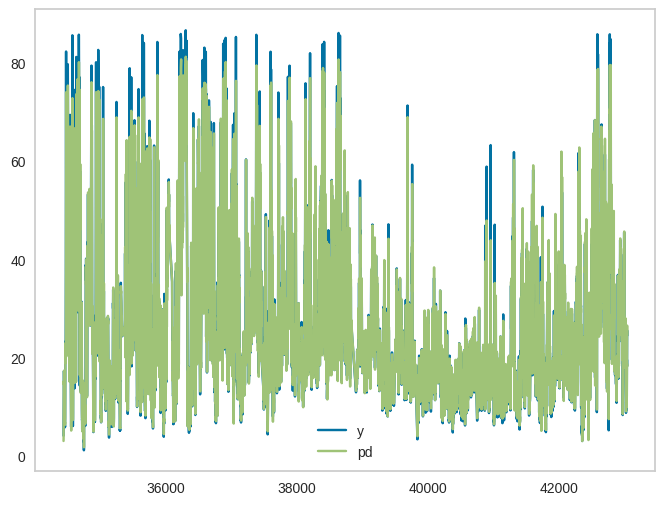

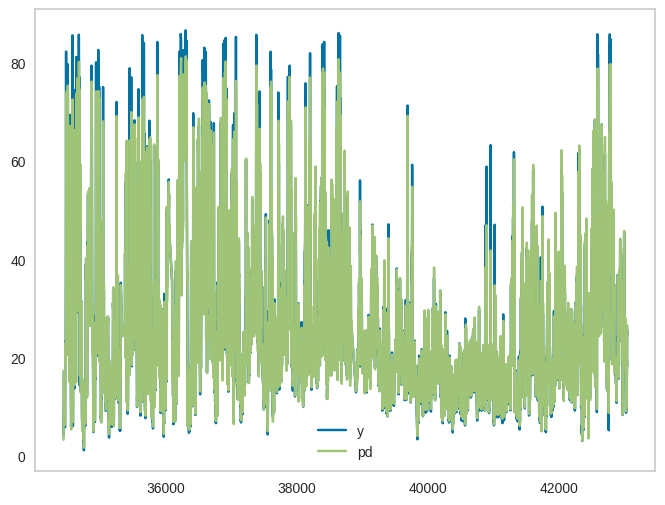

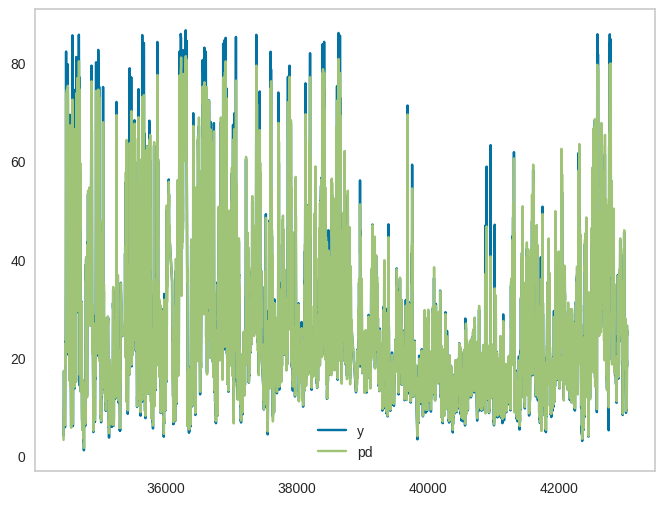

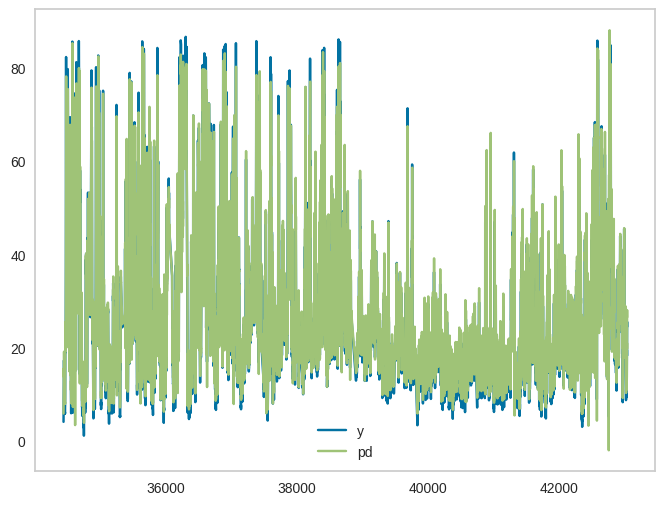

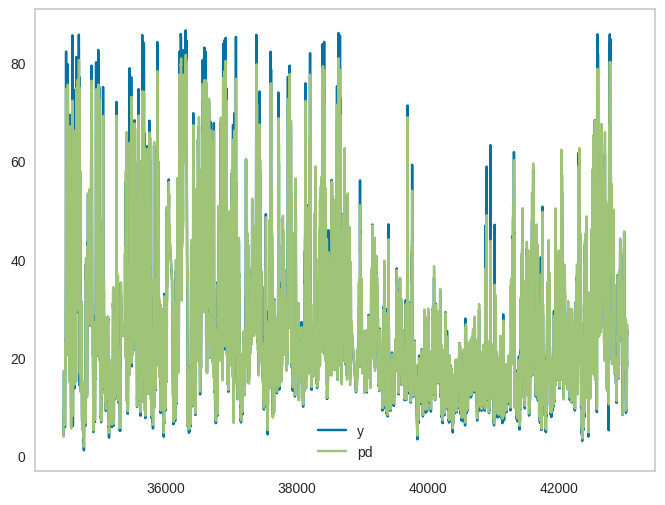

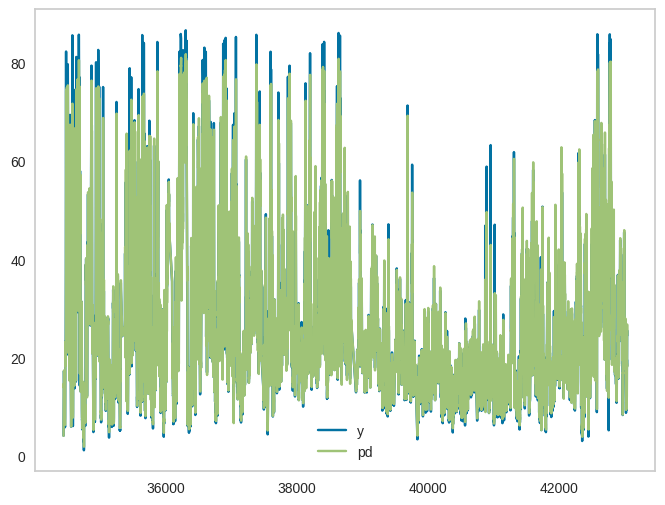

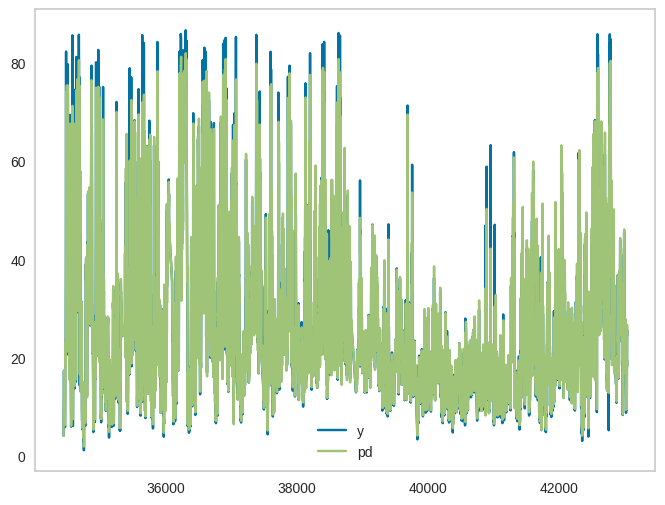

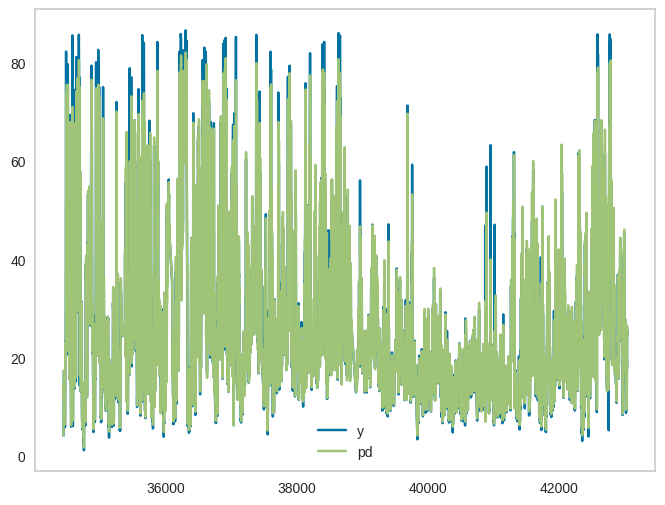

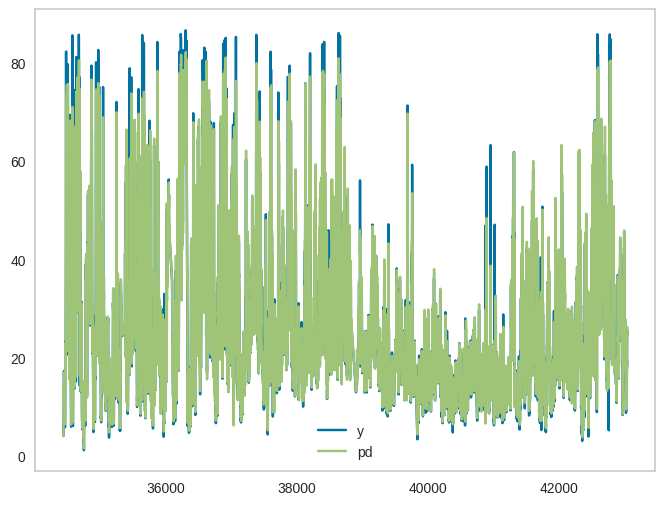

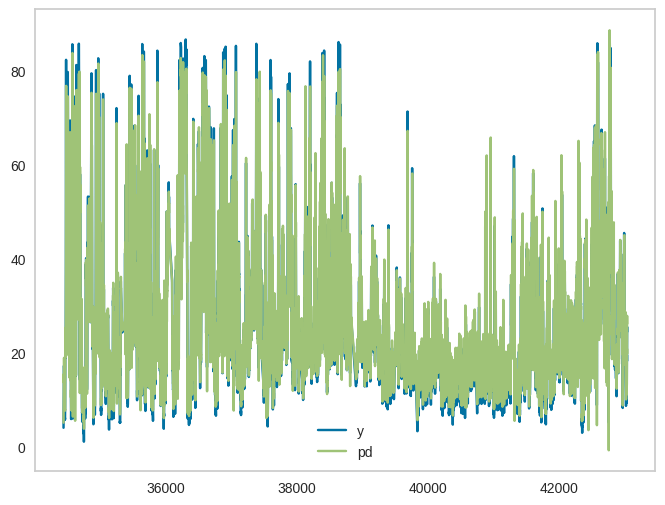

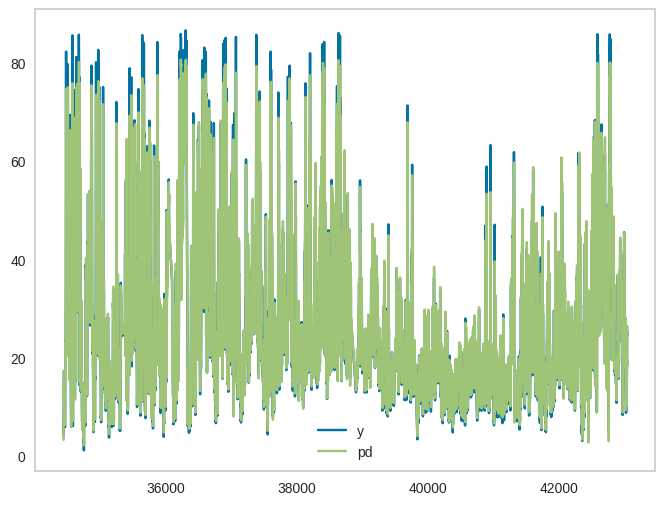

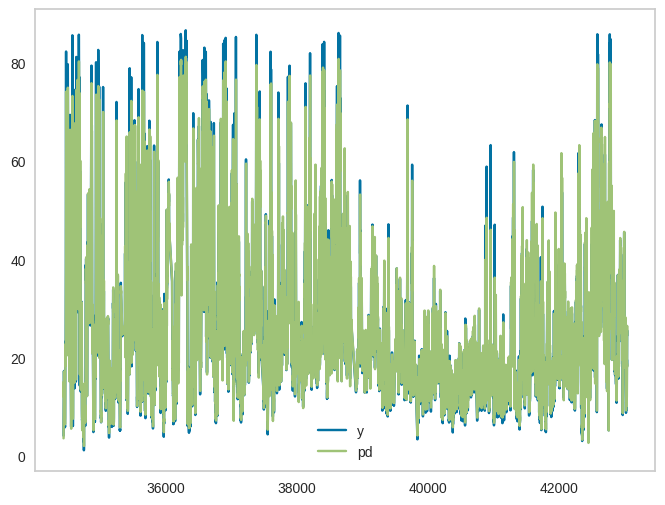

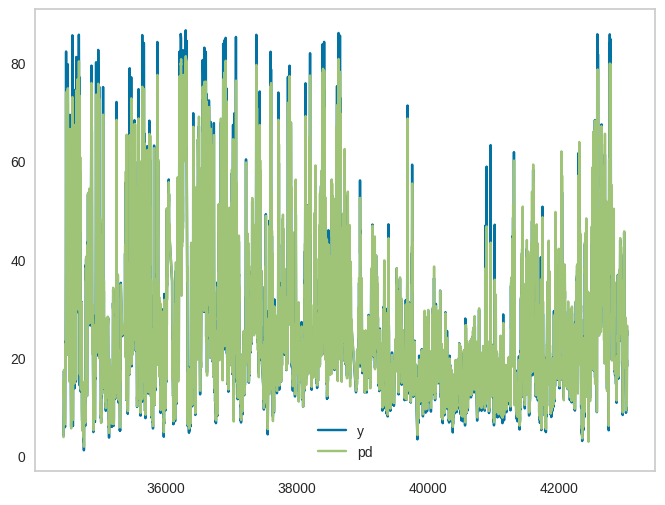

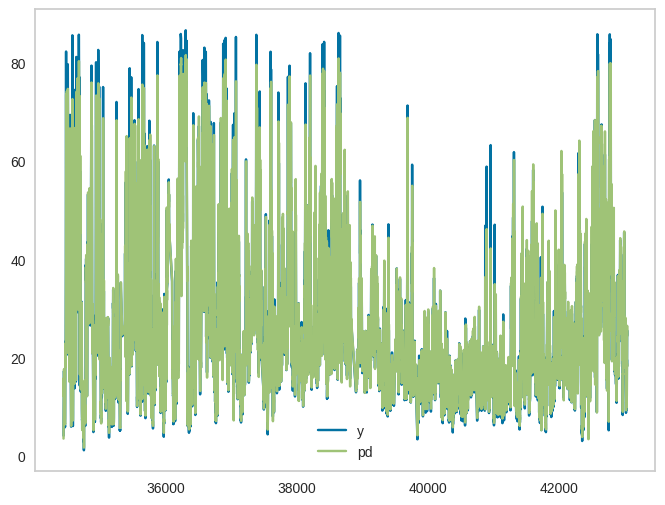

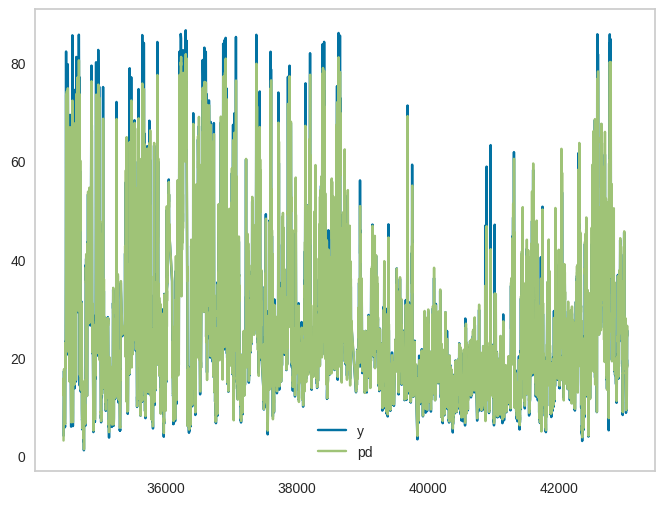

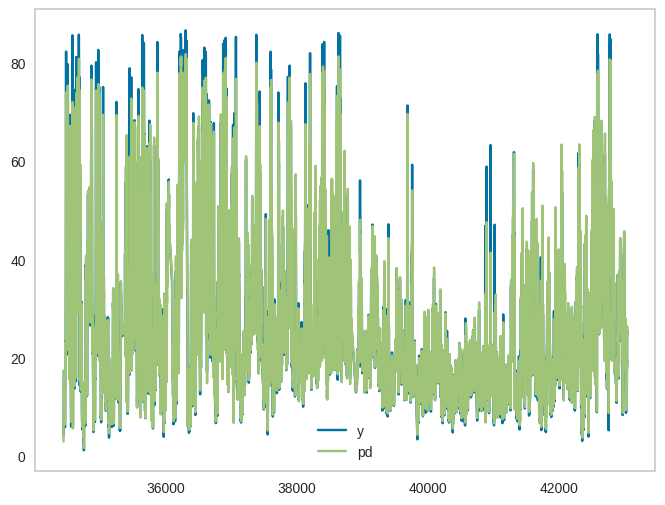

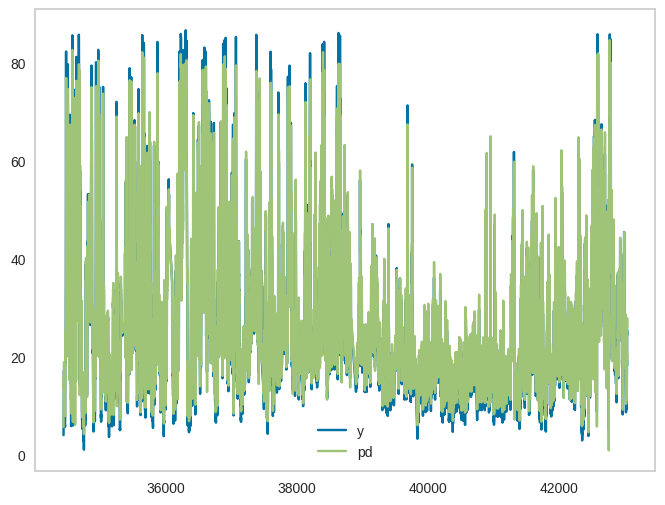

In [ ]:


seasonality_min=Seasonality_min_val(df)
data_array=df.to_numpy()
views_upto=10
Start_view=2
Results=[]
Results_GAB=[]

for view_max in range(Start_view, views_upto+1):
    ViewsDataset=MVL_Data_Generator(data_array,seasonality_min, view_max)
###################
    view_accuracy=[]
    Traditional_model_pred=[]
    valid_performance_val=[]
    df.columns = ['y']

    y_train_en, y_val_en, y_test_in, x_train_en, x_val_en, x_test_en, test_en, scale_en, en_df, val_en, train_en =DataTrainTestVal(df)
    models=[]

    model_LSTM, model_GRU, model_CNN, model_RNN, model_BiLSTM =create_model(x_train_en, units=32)

    models.append(model_BiLSTM)
    #models.append(model_LSTM)
    #models.append(model_GRU)
    #models.append(model_CNN)
    #models.append(model_RNN)

    view_accuracy,valid_performance_i,Test_Predictions,y_test_original,Total_Train_Prediction=Model_Execution(models,x_train_en, y_train_en, x_val_en, y_val_en, x_test_en, y_test_in, test_en, scale_en, en_df, val_en, train_en, batch_size=64)

    Traditional_model_pred.append(Test_Predictions)
    valid_performance_val.append(valid_performance_i[0])

    #########################################  Multi-view Time Series Analysis  #######################
    serial=0
    view_predictions=[]
    GAB_final_predictions=[]

    for view in ViewsDataset:
      print('length of the views:',len(view))
      df_new = pd.DataFrame(view)
      df_new.columns = ['y']
      y_train_en, y_val_en, y_test_in_na, x_train_en, x_val_en, x_test_en_na, test_en_na, scale_en, en_df, val_en_na, train_en_na =DataTrainTestVal(df)
      #y_train_en, y_val_en, y_test_in_na, x_train_en, x_val_en, x_test_en_na=DataTrainTestVal(df_new)

      y_train=np.concatenate((y_train_en, y_val_en), axis=0)
      x_train=np.concatenate((x_train_en, x_val_en), axis=0)

      Train_combined = pd.concat([train_en, val_en], ignore_index=True)
      
      y_val=y_test_in_na
      x_val=x_test_en_na

      Test_Predictions=pd.DataFrame()
      Train_Predictions=pd.DataFrame()
      
      print('Data views number ============>',serial,'/',view_max,'<================')
      serial=serial+1 
      
      #print("len(y_train_en)=",y_train_en, "len(x_train_en)=", x_train_en)

      #view_accuracy.append(Model_Execution(models,x_train, y_train, x_val, y_val,x_test_en, y_test_in, batch_size=64))
      # test_en_na has been utilized for validation purpose of specific view
      view_accuracy_i,valid_performance_i,Test_Predictions_i,ytest_original, Total_Train_Prediction=Model_Execution(models, x_train, y_train, x_val, y_val, x_test_en, y_test_in, test_en, scale_en, en_df, test_en_na, Train_combined, batch_size=64)

      view_accuracy.append(view_accuracy_i)
      #print('shape of predictions:',np.array(Test_Predictions_i).shape)
      view_predictions.append(Test_Predictions_i)
      valid_performance_val.append(valid_performance_i[0])


      Total_Train=np.append(y_train, y_val)

      #converting in single list of "Test_Predictions_i" variable
      Test_Predictions_ii=[]
      for tt in Test_Predictions_i:
        Test_Predictions_ii.append(tt[0])

      GAB_final_predictions_i=GradientBias(Total_Train, Total_Train_Prediction, Test_Predictions_ii)
      GAB_final_predictions_i.append(GAB_final_predictions_i[-1])

      GAB_final_predictions.append(GAB_final_predictions_i)
      #print("GAB_final_predictions_i=",GAB_final_predictions_i)
    #view_predictions.append(ytest_original.tolist())
    #y_train_en, y_val_en, y_test_in, x_train_en, x_val_en, x_test_en=DataTrainTestVal(df)

    #required variable===>  Total_Train, Total_Train_Prediction,Test_Predictions_i,ytest_original
    #print("Training Length"+str(Total_Train.shape()))
    #print("Training Prediction Length"+str(Total_Train.shape()))
    #print("GAB_final_predictions==========>>>>>>>",GAB_final_predictions)



    # Pure multi-view learning results ....................................................................................
    Results_i=MultiviewEnsemble(Traditional_model_pred,view_predictions, y_test_original,valid_performance_val, view_max)

    #Formate preparation as per view_predictions format to GAB_final_predictions
    view_predictions_GAB=[]
    for zz in GAB_final_predictions:
      view_predictions_GAB.append([[x] for x in zz])
    # Pure multi-view+GAB learning results ....................................................................................
    GAB_results_i=MultiviewEnsemble(Traditional_model_pred,view_predictions_GAB, y_test_original,valid_performance_val, view_max)
    Results.append(Results_i)
    Results_GAB.append(GAB_results_i)



In [ ]:
for kk in Results:
    print(kk)

In [ ]:
for kk in Results_GAB:
    print(kk)